# Shreyank Shetty (12279686)
## FINM 33150 1 Regression Analysis and Quantitative Trading Strategies
### Homework: Return Predictions from trade flow 



In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import warnings
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from sklearn.model_selection import train_test_split
import requests
import csv
import os
import json 
from datetime import datetime, timedelta
from matplotlib import cm
from scipy.stats import zscore
plt.rcParams["figure.figsize"] = (16,10)
warnings.filterwarnings('ignore')

### Extracting the book data 

In [82]:
file_path='/Users/shreyankshetty/Documents/QuantTradingStrats/week4/data'
btc_usd = pd.read_csv(file_path+'/book_narrow_BTC-USD_2021.delim', sep='\t')
eth_btc=pd.read_csv(file_path+'/book_narrow_ETH-BTC_2021.delim', sep='\t')
eth_usd=pd.read_csv(file_path+'/book_narrow_ETH-USD_2021.delim', sep='\t')


### Extracting the trade data 

In [83]:
file_path='/Users/shreyankshetty/Documents/QuantTradingStrats/week4/data'
tr_btc_usd = pd.read_csv(file_path+'/trades_narrow_BTC-USD_2021.delim', sep='\t')
tr_eth_btc = pd.read_csv(file_path+'/trades_narrow_ETH-BTC_2021.delim', sep='\t')
tr_eth_usd = pd.read_csv(file_path+'/trades_narrow_ETH-USD_2021.delim', sep='\t')


In [84]:
tr_btc_usd

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618090136118837000,1618090132515484000,59120710000,9701240,-1.0
1,1618090136118594000,1618090132515484000,59125070000,8122450,-3.0
2,1618090136147838000,1618090132989553000,59119950000,6563880,-1.0
3,1618090136147583000,1618090132989553000,59125070000,614120,-1.0
4,1618090136153326000,1618090133074765000,59119950000,16995890,-1.0
...,...,...,...,...,...
6268833,1619482936376487000,1619482936402878000,53734710000,7830010,-1.0
6268834,1619482936375914000,1619482936402878000,53737420000,113369990,-2.0
6268835,1619482936398762000,1619482936428058000,53737420000,1796160,1.0
6268836,1619482936638885000,1619482936667433000,53734660000,3641360,1.0


### Pre Processing The Data

In [85]:
def f1(x):
    if x > 0:
        return 1
    else:
        return -1

#### Generating a single dataframe with tau period flow and T period forward return for unique timestamps

In [194]:
def get_tau_flow(pair,tau):  
    new=pair.groupby('timestamp_utc_nanoseconds').sum()['flow'].cumsum()
    new=new.shift(1)
    #tau=1
    new_tau= new.copy(deep=True)
    new_tau.index += tau*10**9 #30 seconds
    comb=pd.concat([new.to_frame('new'), new_tau.to_frame('new_tau')], axis=0)
    comb.sort_index(inplace=True)
    comb.fillna(method='ffill', inplace=True)
    comb['tauFlow']= comb['new']- comb['new_tau']
    tauFlow= comb.loc[new.index].dropna()
    return tauFlow
    #tauFlow['tauFlow'].plot()

def get_T_price(pair,T):
    price=pair.groupby('timestamp_utc_nanoseconds').last()['PriceMillionths']
    price=price.shift(1)
    #T=1
    for_price= price.copy(deep=True)
    for_price.index -= T*10**9 #30 seconds
    comb=pd.concat([price.to_frame('price'), for_price.to_frame('for_price')], axis=0)
    comb.sort_index(inplace=True)
    comb.fillna(method='bfill', inplace=True)
    comb['ret']= (comb['for_price']- comb['price'])/comb['price']
    price_df= comb.loc[price.index].dropna()
    #price_df['ret'].plot()
    return price_df
    

#### Running the Regression and generating signals 

In [132]:
def run_reg(pair_tau,pair_price,j,band):  
    data= pd.merge(pair_tau, pair_price,left_index=True, right_index=True)
    data_train,data_test = train_test_split(data,test_size=0.8,shuffle=False)
    reg= sm.OLS(data_train['ret'],data_train['tauFlow']).fit()
    reg.summary()

    beta= reg.params[0]
    pvalue= reg.pvalues[0]
    r_sqaured= reg.rsquared
    data_test['pred_ret']= beta*data_test['tauFlow']
    
    #j=0.5e-16
    data_test['signal']= np.where(data_test['pred_ret']>j+band,1,np.where(data_test['pred_ret']<-(j+band),-1,0))
    data_test['realized_ret']= data_test['signal']*data_test['ret']
    
    #df= generate_signal(data_test)
    return data_test,beta,pvalue, r_sqaured

# Analysis for BTC_USD 

Creating a band, such that trading happens only on the outlier, this is to reduce the trading frequency. Esentially the strategy looks at extreme points to enter long or short positions. 

#### Selection of j

I selected j as the 75 percentlie of my predicted returns  

In [296]:
tau=2
T=3
j=5e-08
band=5e-04 # creating a band to restrict the trade signals

In [297]:
tr_btc_usd['nside']= tr_btc_usd['Side'].apply(f1)
tr_btc_usd['flow'] = tr_btc_usd['SizeBillionths'] * tr_btc_usd['nside']

pair_tau= get_tau_flow(tr_btc_usd,tau)  
pair_price= get_T_price(tr_btc_usd,T) 

data,beta,pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)


MIN Correlation pair is ('tauFlow', 'for_price')
MAX Correlation pair is ('for_price', 'for_price')


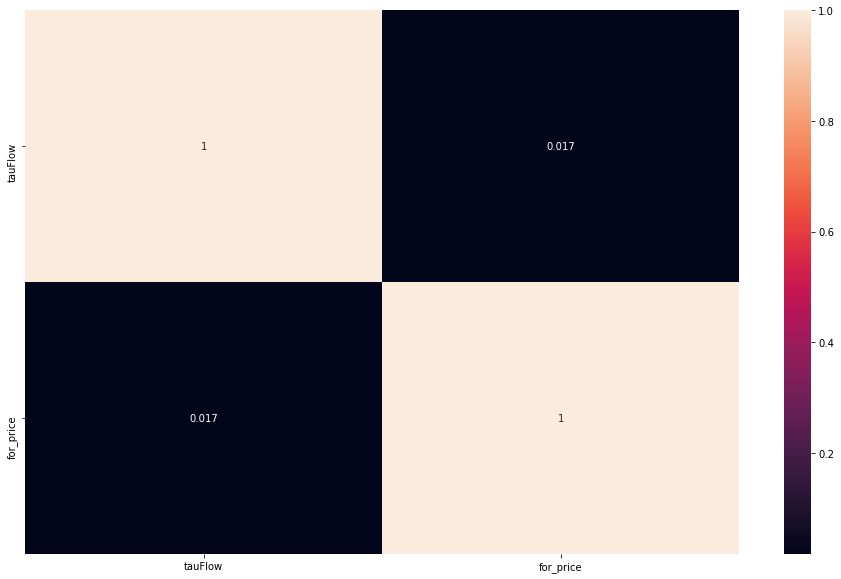

In [275]:
def display_corr(df, print_maxmin=True):
    
    corr = df.corr()
    sns.heatmap(corr, annot=True)
    if print_maxmin:
        corr_rank = corr.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]
        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')
df = data[['tauFlow', 'for_price']]
display_corr(df)

We can see from the correlation matrix that these two variables have very low correlation. Hence the r-sqaured for the regression will also be low.

<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

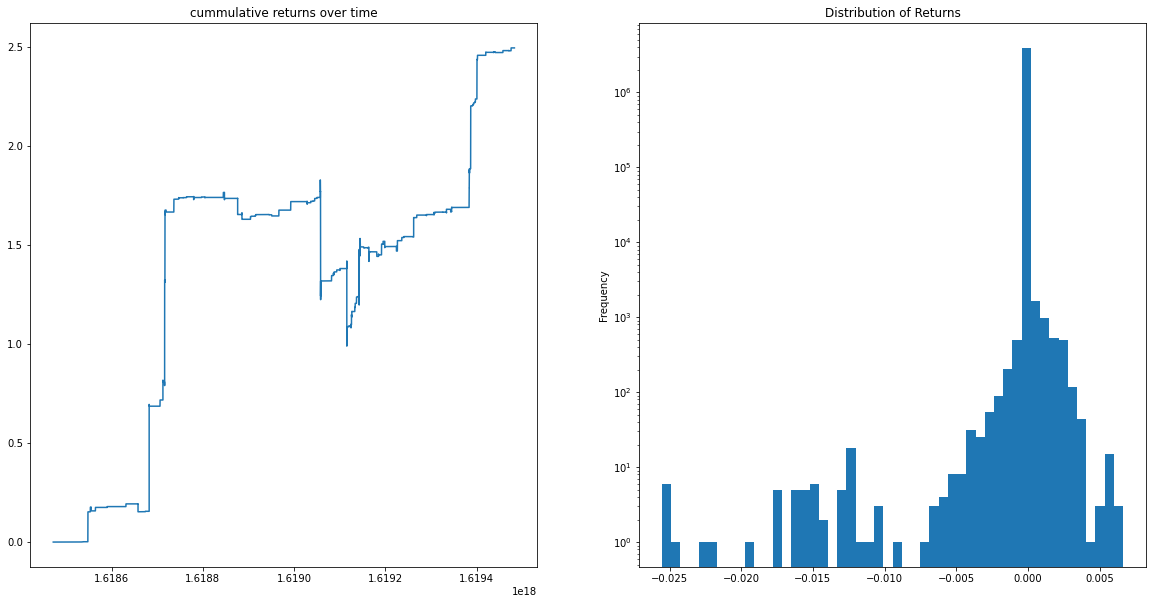

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax[0].plot(data['realized_ret'].cumsum())
ax[0].set_title("cummulative returns over time")

ax[1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=50, log=True ,ax=ax[1])

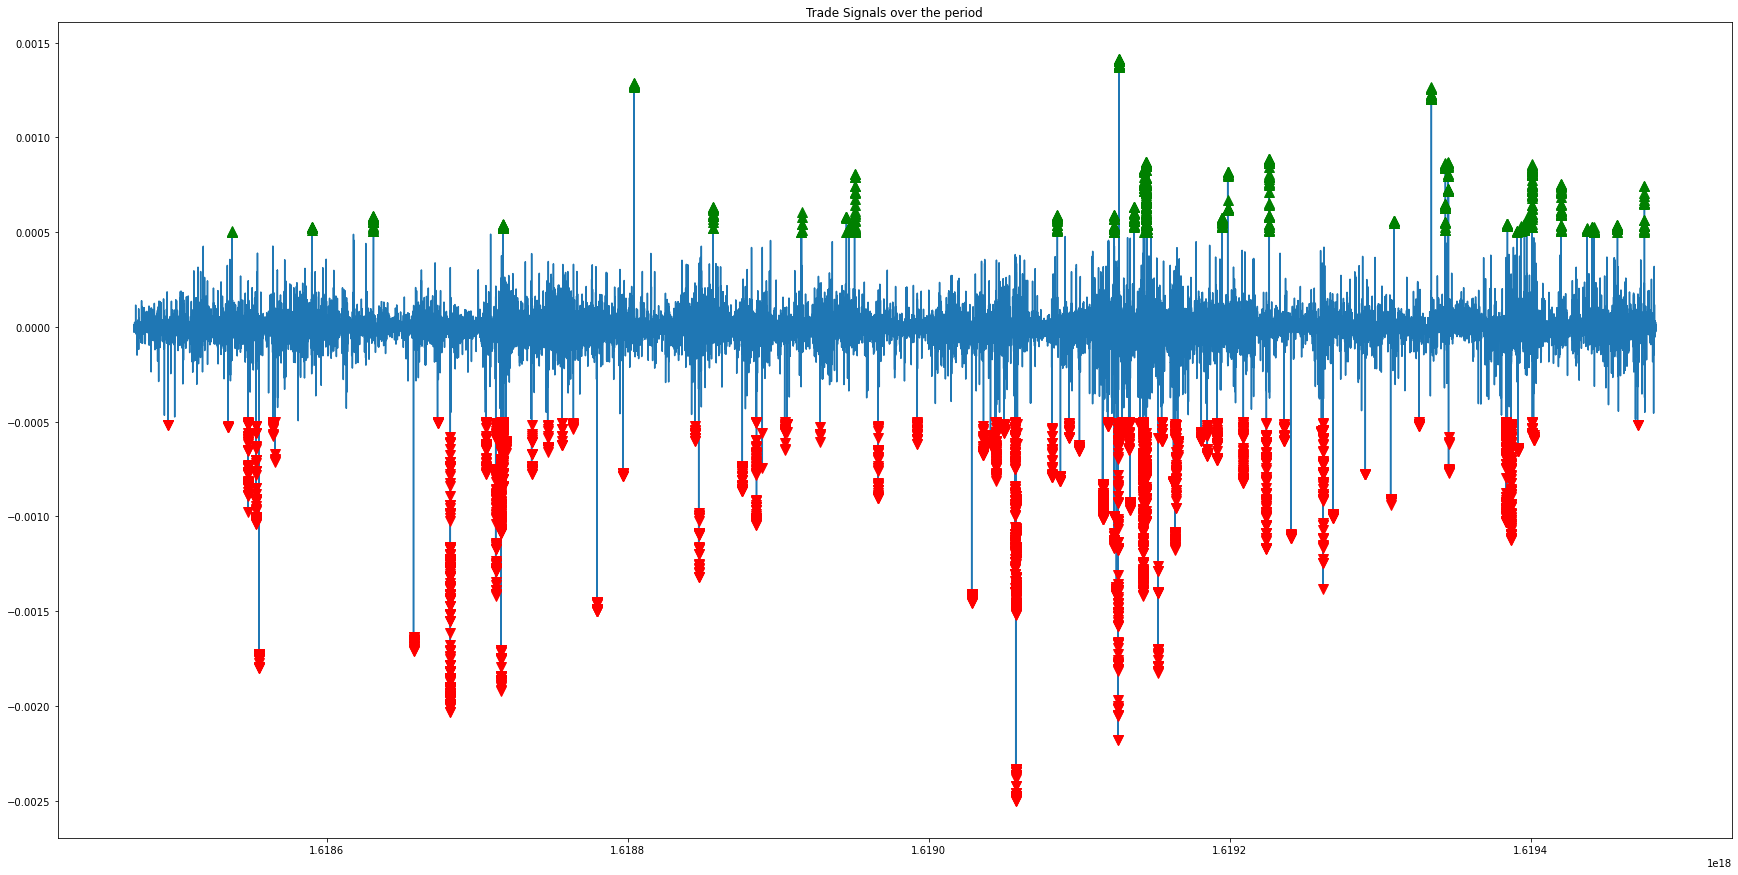

In [139]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

### Changing Parameters of Tau, T and J 

Trading based on a signle point value of J, i.e no band. Comparing it with the previous case of trading on outliers only. 


This is under the assumption that there is infinite balance, and you can trade at every signal.(which is an extremely unrealistic assumption to make). 


None the less, we are reviewing the performance of strategy in such a scenario below. 

In [276]:
tau=4
T=4
j=5e-08
band=0

In [144]:
pair_tau= get_tau_flow(tr_btc_usd,tau)  
pair_price= get_T_price(tr_btc_usd,T) 

data,beta,pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)

<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

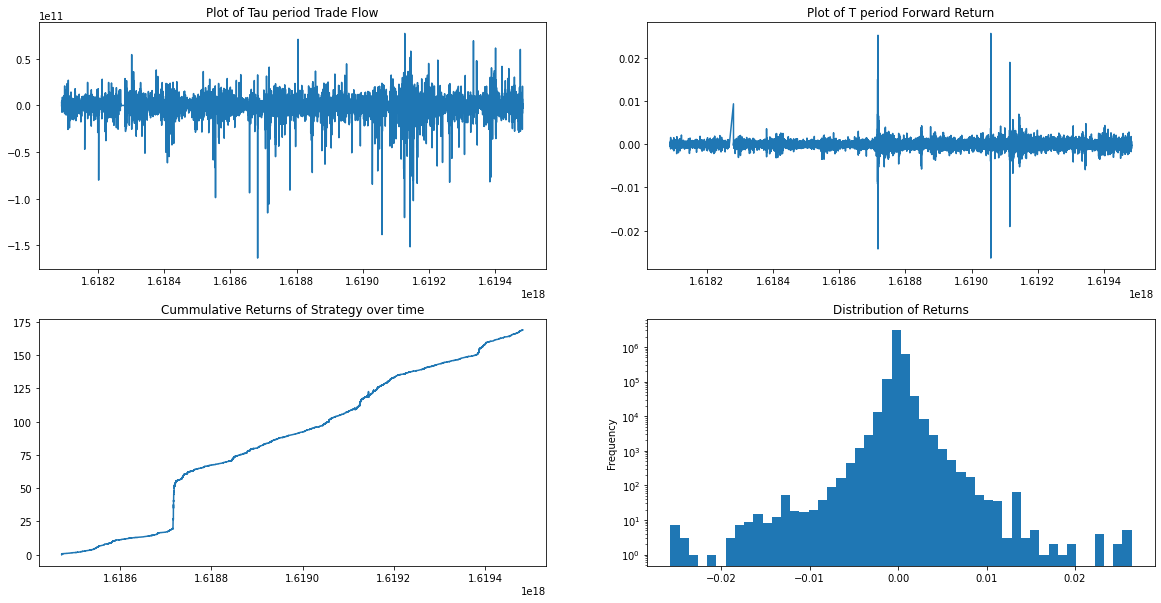

In [148]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

ax[0][0].plot(pair_tau['tauFlow'])
ax[0][0].set_title("Plot of Tau period Trade Flow")

ax[0][1].plot(pair_price['ret'])
ax[0][1].set_title("Plot of T period Forward Return")

ax[1][0].plot(data['realized_ret'].cumsum())
ax[1][0].set_title("Cummulative Returns of Strategy over time")

ax[1][1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=50, log=True ,ax=ax[1][1])


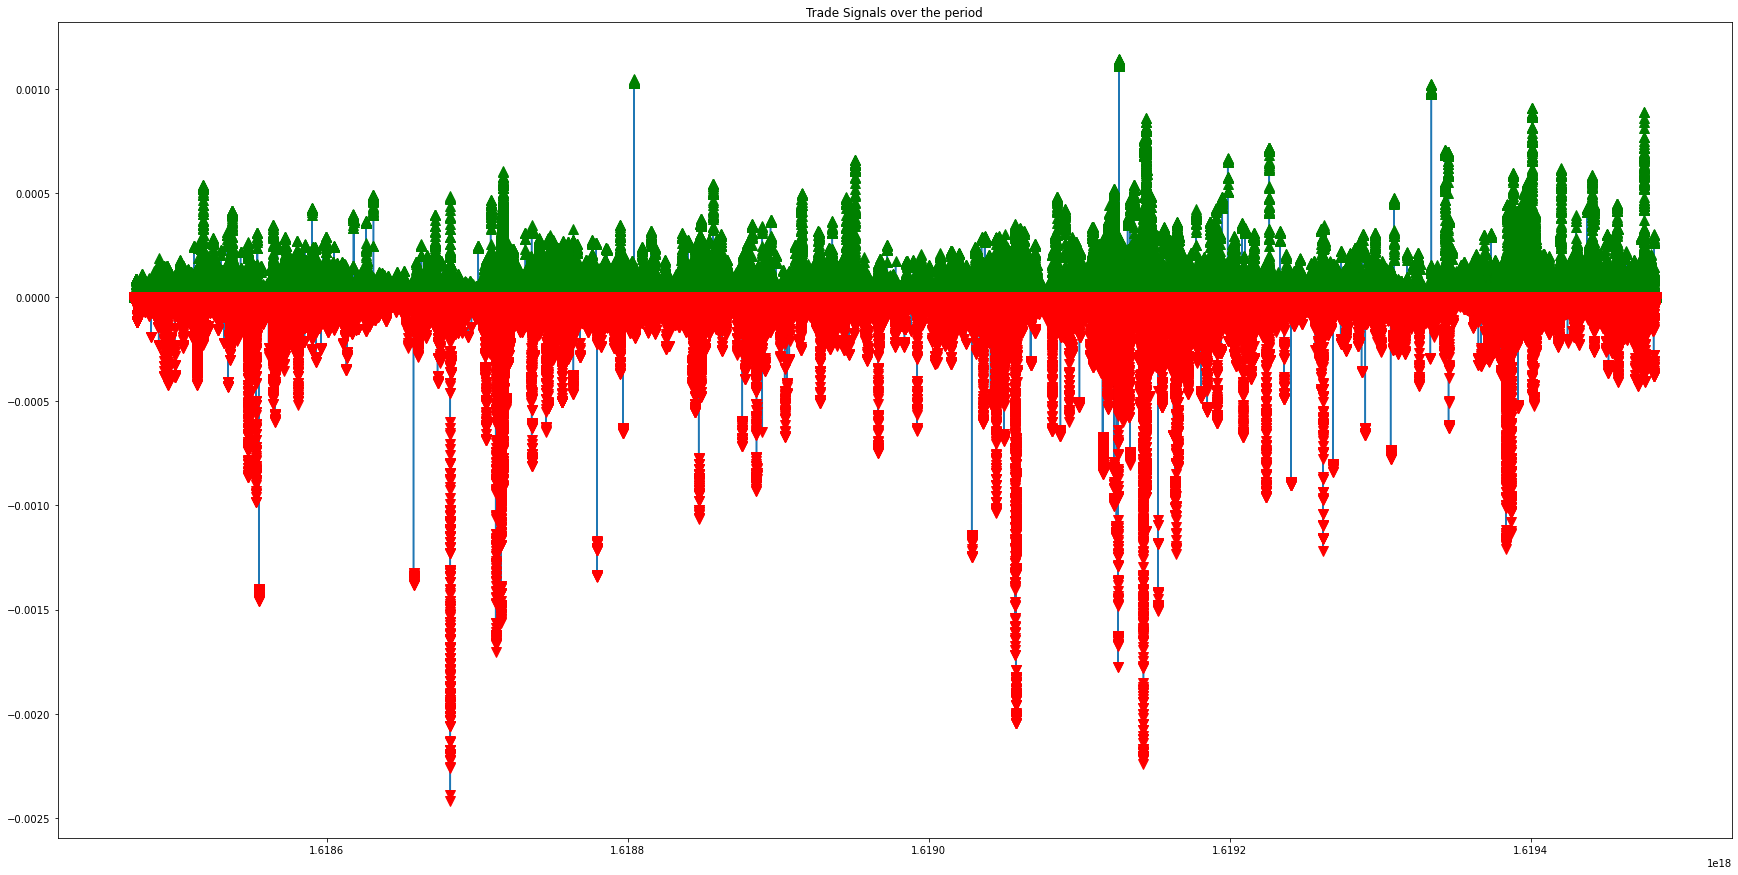

In [149]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

As we can see here there are many trade signals, hence the stratgey takes too many positions, which would not be possible in a realistic environment as the time periods are extremely small, and total available balance to trade would not be sufficient. 

Also Note our performance is also taking a hit as we increase frequency of trading. (This is without taking into consideration trading cost which would bring down the return further). 

#### The Regression Summary 

In [232]:
beta,pvalue, r_sqaured
print("The Beta of the regression: "+ str(beta)+ "\nThe P value: "+ str(pvalue)+ "\nThe R-Sqaured :"+ str(r_sqaured))

The Beta of the regression: -5.899628929831116e-16
The P value: 0.017658950682868872
The R-Sqaured :0.0009034481802291383


The pvalue of is good, we can trust our beta. 

The R-sqaured of the regression is extremely low. This is a worrying factor. We x term(trade flow) is not moving along with the y term(forward return) 

# Analysis for eth_btc 

In [277]:
tau=1000
T=200
j=5e-08
band=5e-05

In [278]:
tr_eth_btc['nside']= tr_eth_btc['Side'].apply(f1)
tr_eth_btc['flow'] = tr_eth_btc['SizeBillionths'] * tr_eth_btc['nside']

pair_tau= get_tau_flow(tr_eth_btc,tau)  
pair_price= get_T_price(tr_eth_btc,T) 

data,beta, pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)


MIN Correlation pair is ('tauFlow', 'for_price')
MAX Correlation pair is ('for_price', 'for_price')


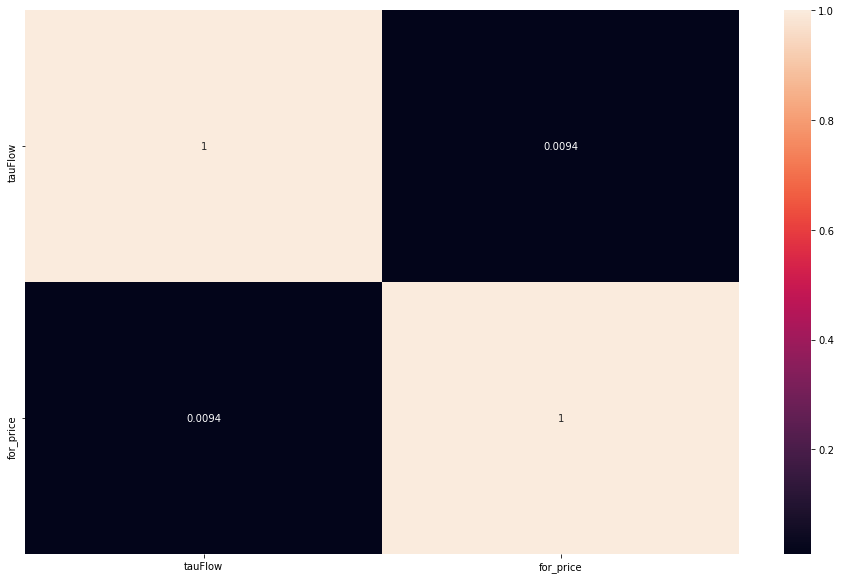

In [279]:
def display_corr(df, print_maxmin=True):
    
    corr = df.corr()
    sns.heatmap(corr, annot=True)
    if print_maxmin:
        corr_rank = corr.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]
        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

df = data[['tauFlow', 'for_price']]
display_corr(df)

<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

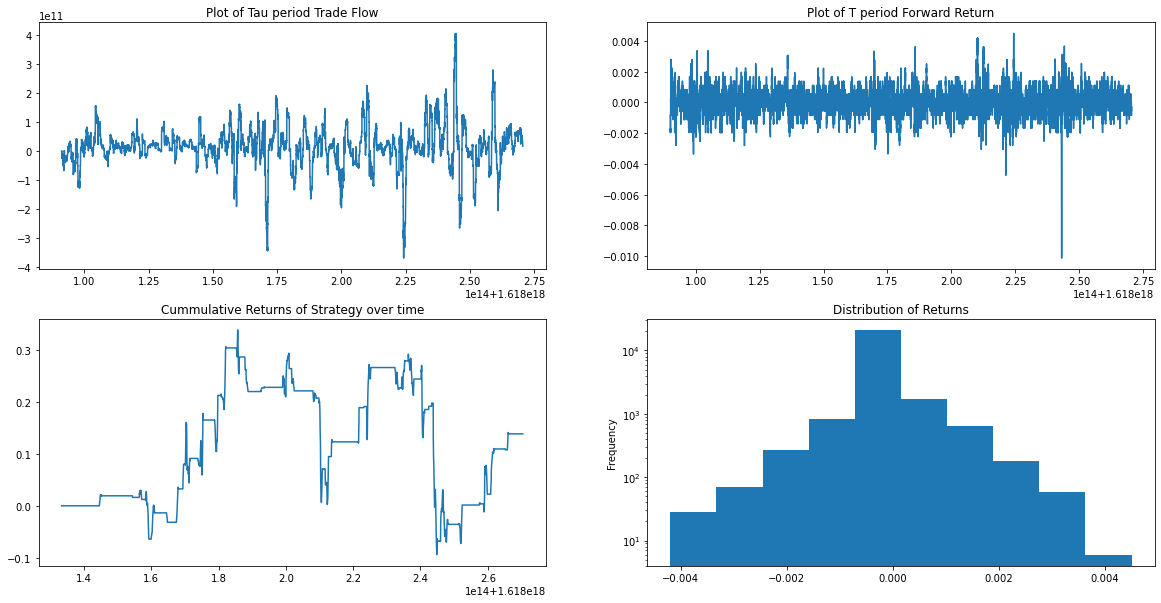

In [227]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

ax[0][0].plot(pair_tau['tauFlow'])
ax[0][0].set_title("Plot of Tau period Trade Flow")

ax[0][1].plot(pair_price['ret'])
ax[0][1].set_title("Plot of T period Forward Return")

ax[1][0].plot(data['realized_ret'].cumsum())
ax[1][0].set_title("Cummulative Returns of Strategy over time")

ax[1][1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=10, log=True ,ax=ax[1][1])



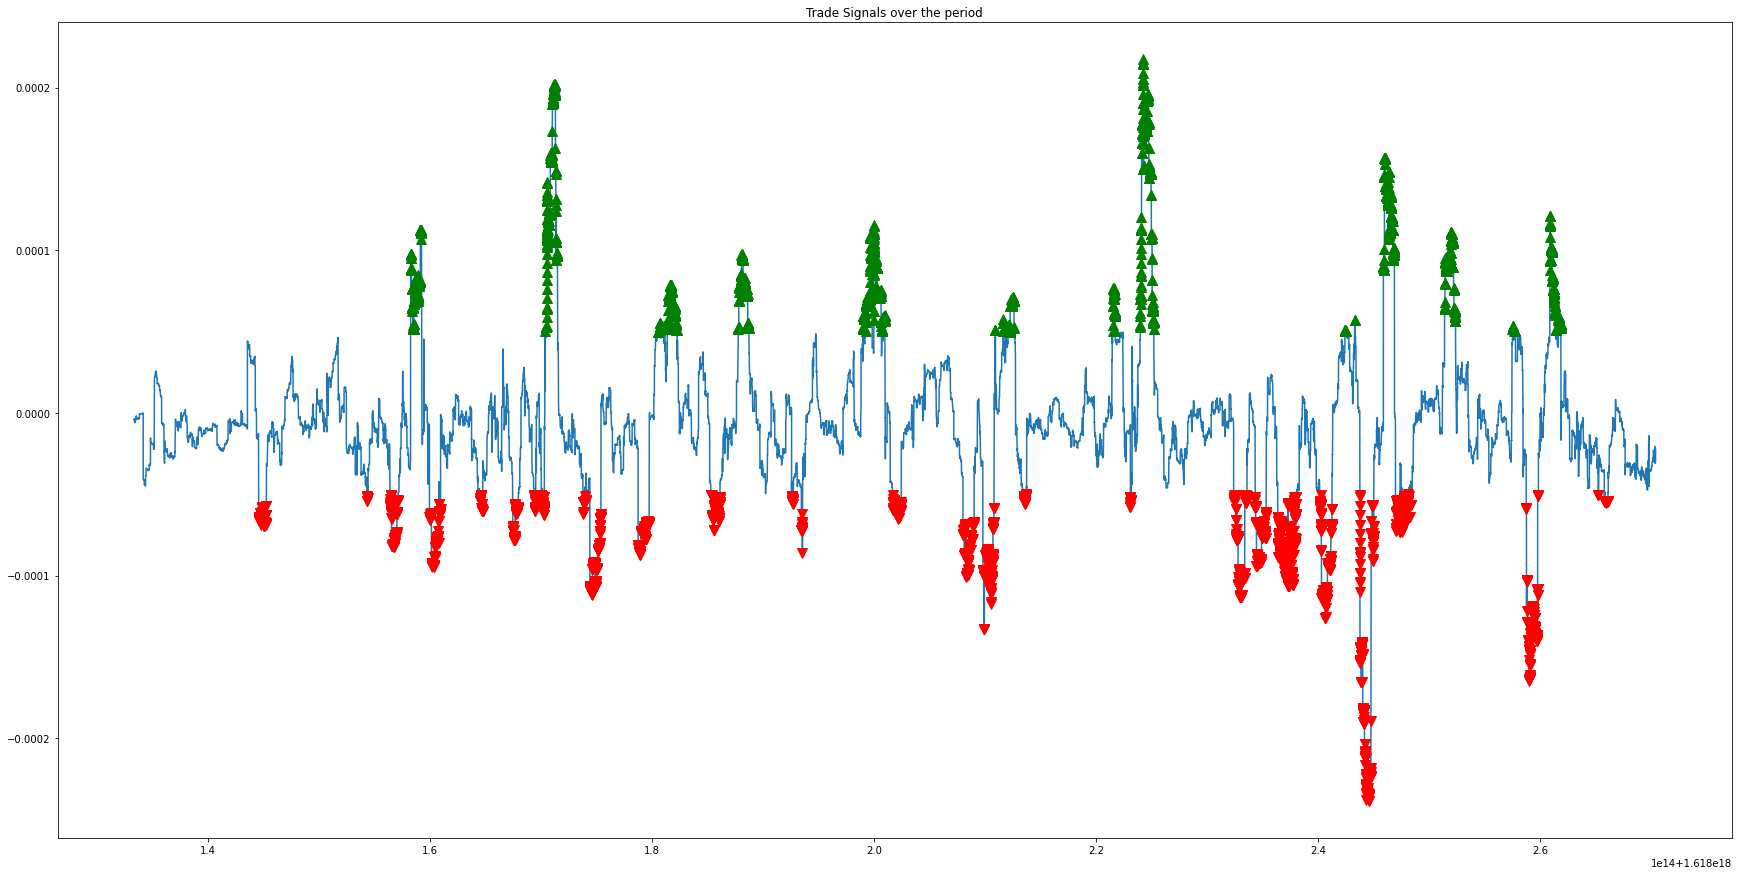

In [229]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

In [233]:
beta,pvalue, r_sqaured
print("The Beta of the regression: "+ str(beta)+ "\nThe P value: "+ str(pvalue)+ "\nThe R-Sqaured :"+ str(r_sqaured))

The Beta of the regression: -5.899628929831116e-16
The P value: 0.017658950682868872
The R-Sqaured :0.0009034481802291383


### Changing the Hyper Parameters

In [243]:
tau=5000
T=2
j=5e-08
band=0

In [244]:
tr_eth_btc['nside']= tr_eth_btc['Side'].apply(f1)
tr_eth_btc['flow'] = tr_eth_btc['SizeBillionths'] * tr_eth_btc['nside']

pair_tau= get_tau_flow(tr_eth_btc,tau)  
pair_price= get_T_price(tr_eth_btc,T) 

data,beta, pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)



<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

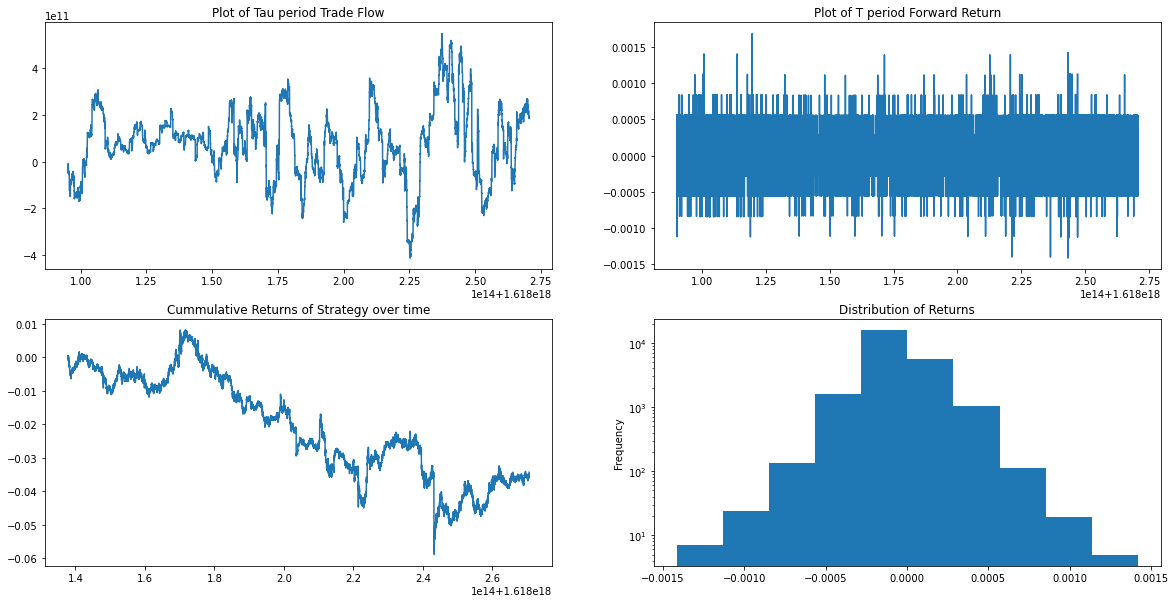

In [245]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

ax[0][0].plot(pair_tau['tauFlow'])
ax[0][0].set_title("Plot of Tau period Trade Flow")

ax[0][1].plot(pair_price['ret'])
ax[0][1].set_title("Plot of T period Forward Return")

ax[1][0].plot(data['realized_ret'].cumsum())
ax[1][0].set_title("Cummulative Returns of Strategy over time")

ax[1][1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=10, log=True ,ax=ax[1][1])




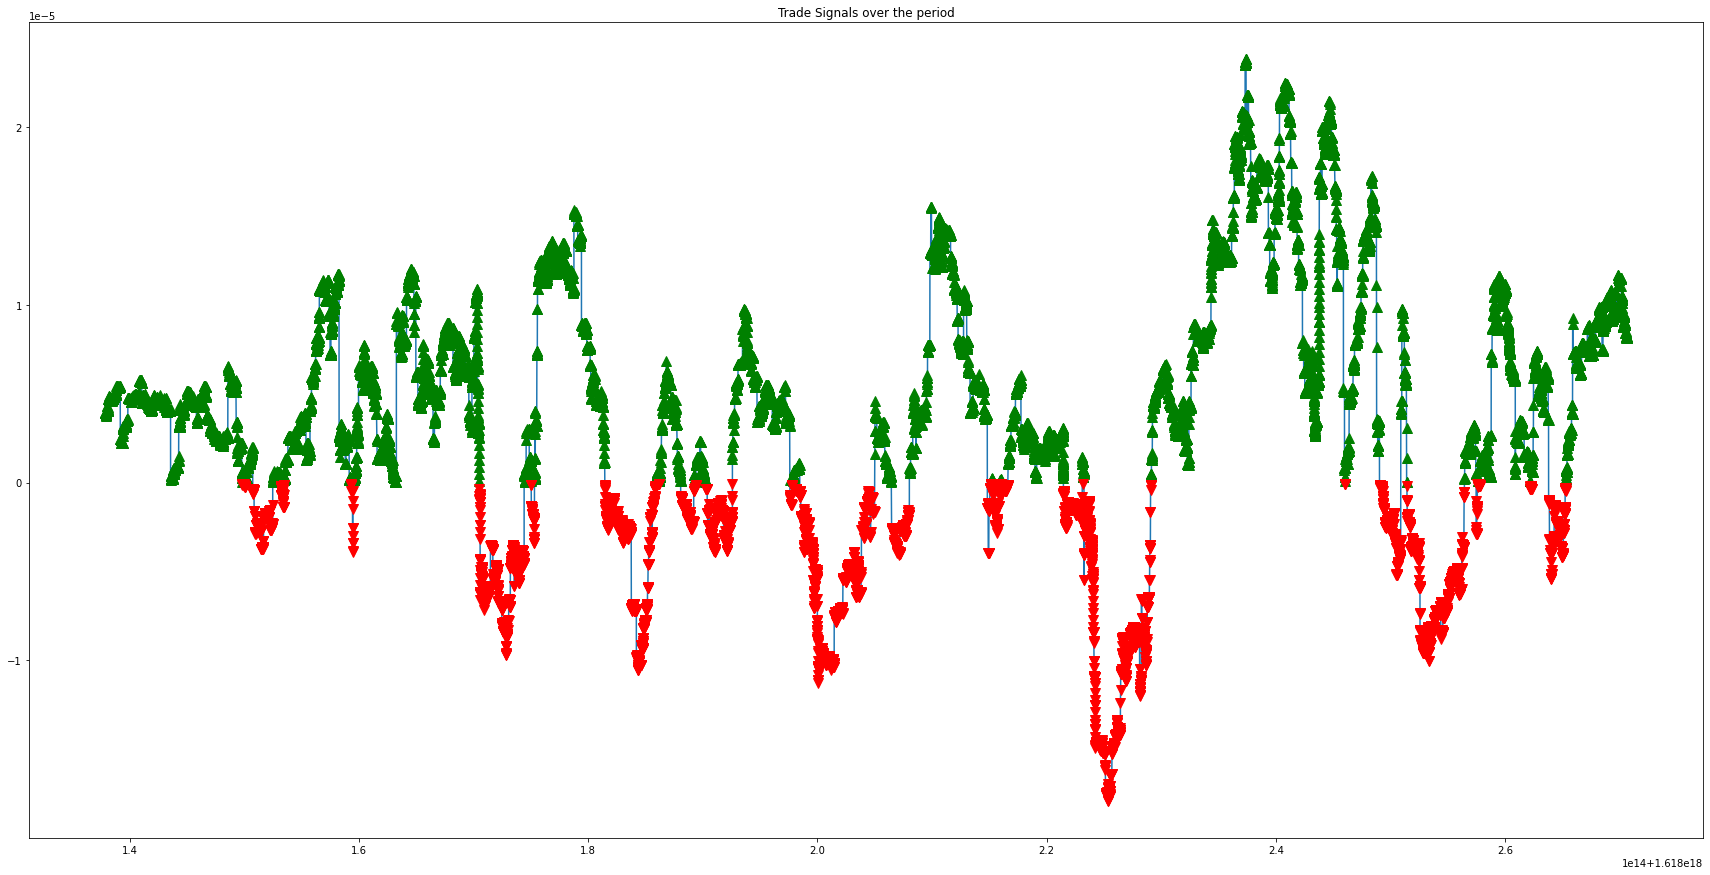

In [246]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

In [247]:
beta,pvalue, r_sqaured
print("The Beta of the regression: "+ str(beta)+ "\nThe P value: "+ str(pvalue)+ "\nThe R-Sqaured :"+ str(r_sqaured))

The Beta of the regression: 4.337683896517694e-17
The P value: 0.11119250452298066
The R-Sqaured :0.0004162898173628582


# Analysis for eth_usd

In [254]:
tau=2
T=3
j=5e-08
band=5e-05

In [255]:
tr_eth_usd['nside']= tr_eth_usd['Side'].apply(f1)
tr_eth_usd['flow'] = tr_eth_usd['SizeBillionths'] * tr_eth_usd['nside']

pair_tau= get_tau_flow(tr_eth_usd,tau)  
pair_price= get_T_price(tr_eth_usd,T) 

data,beta,pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)



MIN Correlation pair is ('tauFlow', 'for_price')
MAX Correlation pair is ('for_price', 'for_price')


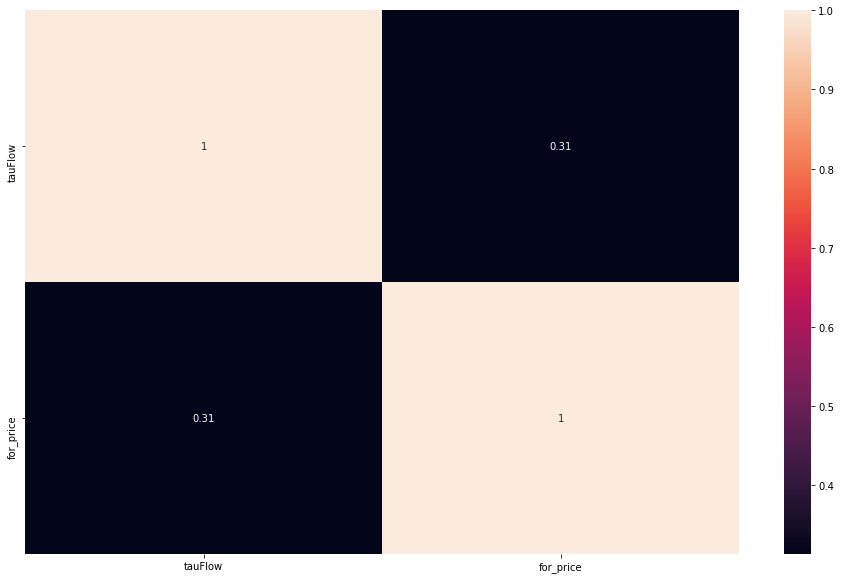

In [272]:
def display_corr(df, print_maxmin=True):
    
    corr = df.corr()
    sns.heatmap(corr, annot=True)
    if print_maxmin:
        corr_rank = corr.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]
        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

df = data[['tauFlow', 'for_price']]
display_corr(df)

<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

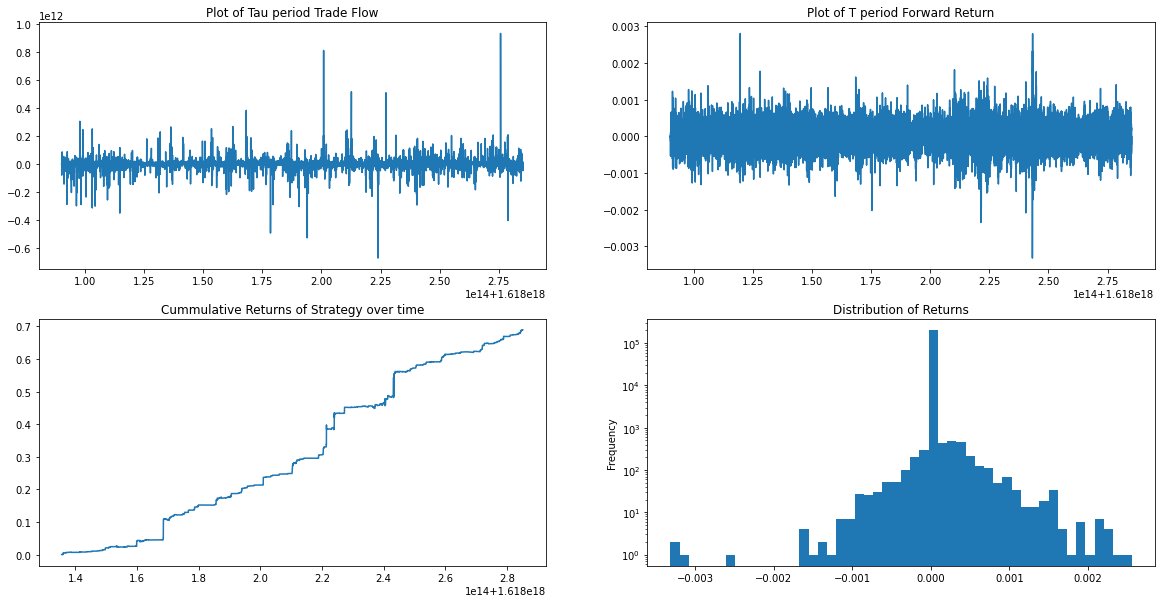

In [256]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

ax[0][0].plot(pair_tau['tauFlow'])
ax[0][0].set_title("Plot of Tau period Trade Flow")

ax[0][1].plot(pair_price['ret'])
ax[0][1].set_title("Plot of T period Forward Return")

ax[1][0].plot(data['realized_ret'].cumsum())
ax[1][0].set_title("Cummulative Returns of Strategy over time")

ax[1][1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=50, log=True ,ax=ax[1][1])

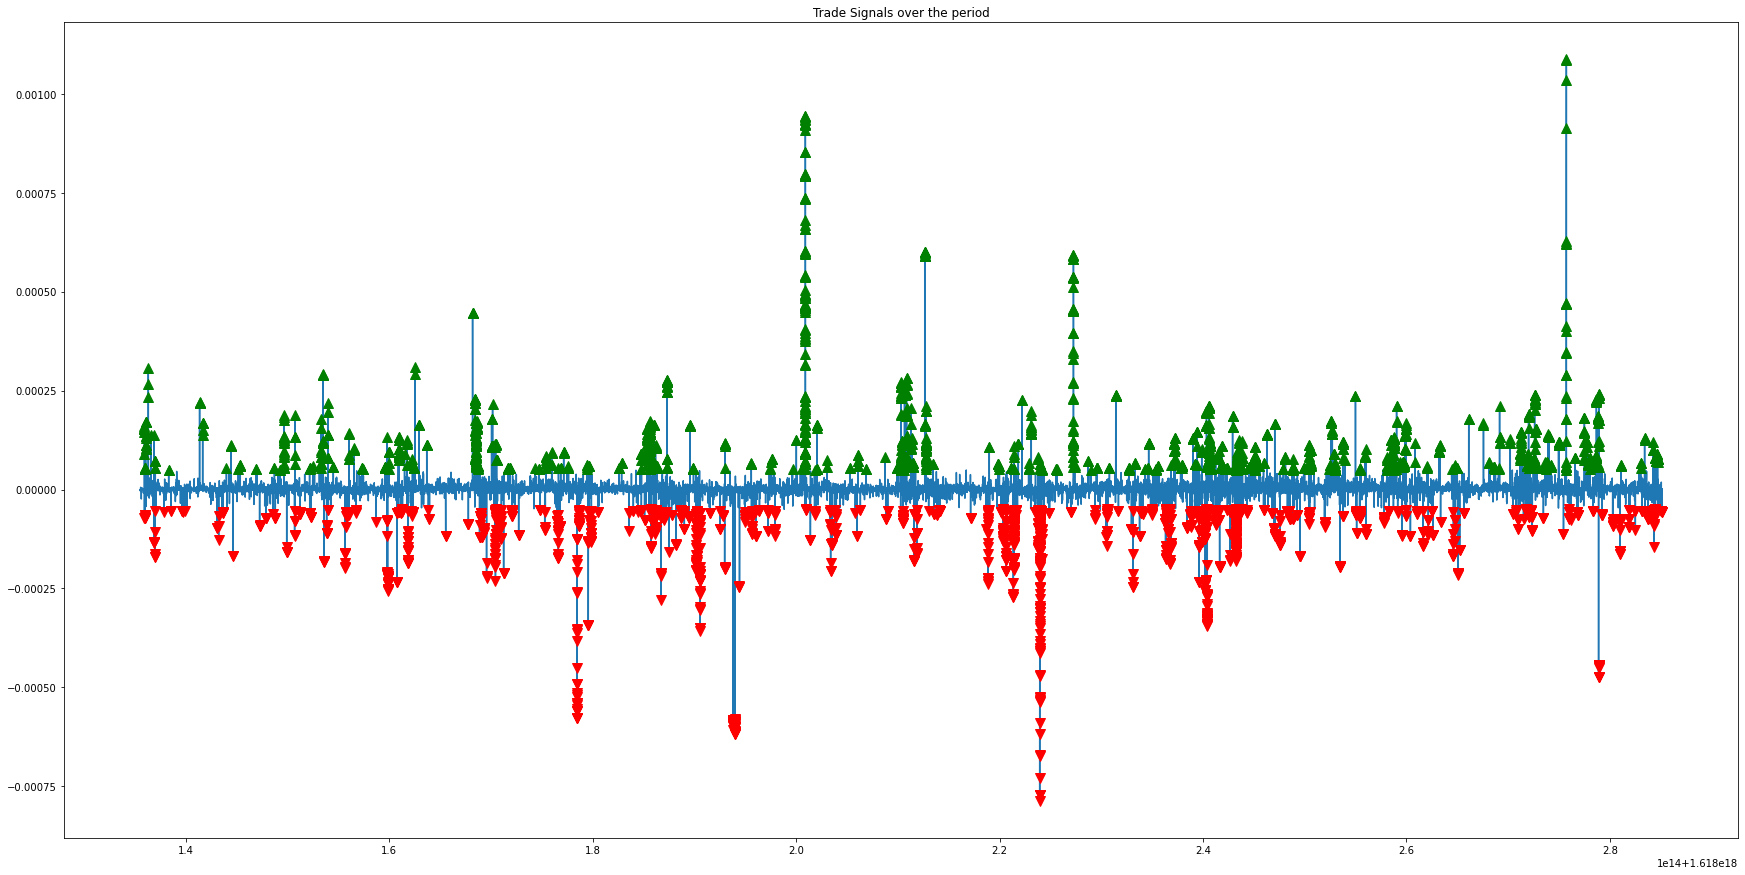

In [257]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

In [258]:
beta,pvalue, r_sqaured
print("The Beta of the regression: "+ str(beta)+ "\nThe P value: "+ str(pvalue)+ "\nThe R-Sqaured :"+ str(r_sqaured))

The Beta of the regression: 1.166812927541697e-15
The P value: 1.972364635090381e-98
The R-Sqaured :0.008468169001910164


The reliabilty of beta is good since the pvalue is close to zero 

#### Changing parameters, using extremely large values for Tau and T

In [261]:
tau=20000
T=300
j=5e-08
band=5e-05

In [262]:
tr_eth_usd['nside']= tr_eth_usd['Side'].apply(f1)
tr_eth_usd['flow'] = tr_eth_usd['SizeBillionths'] * tr_eth_usd['nside']

pair_tau= get_tau_flow(tr_eth_usd,tau)  
pair_price= get_T_price(tr_eth_usd,T) 

data,beta,pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)

<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

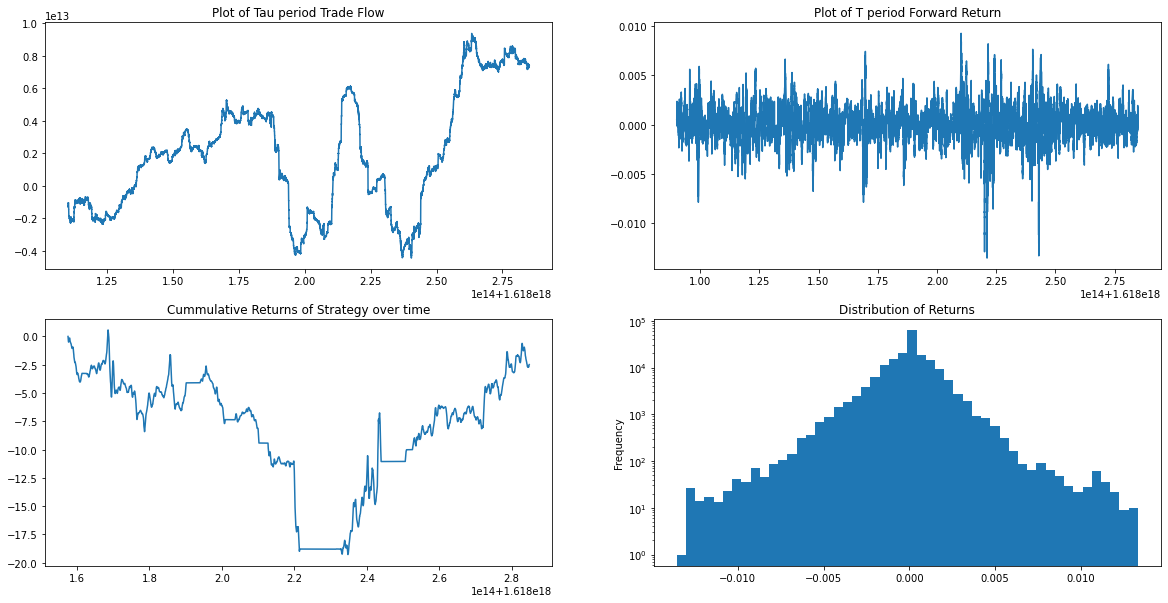

In [263]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

ax[0][0].plot(pair_tau['tauFlow'])
ax[0][0].set_title("Plot of Tau period Trade Flow")

ax[0][1].plot(pair_price['ret'])
ax[0][1].set_title("Plot of T period Forward Return")

ax[1][0].plot(data['realized_ret'].cumsum())
ax[1][0].set_title("Cummulative Returns of Strategy over time")

ax[1][1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=50, log=True ,ax=ax[1][1])

In [264]:
beta,pvalue, r_sqaured
print("The Beta of the regression: "+ str(beta)+ "\nThe P value: "+ str(pvalue)+ "\nThe R-Sqaured :"+ str(r_sqaured))

The Beta of the regression: 2.6452044841187532e-17
The P value: 3.3100975098258216e-10
The R-Sqaured :0.0007361911232366403


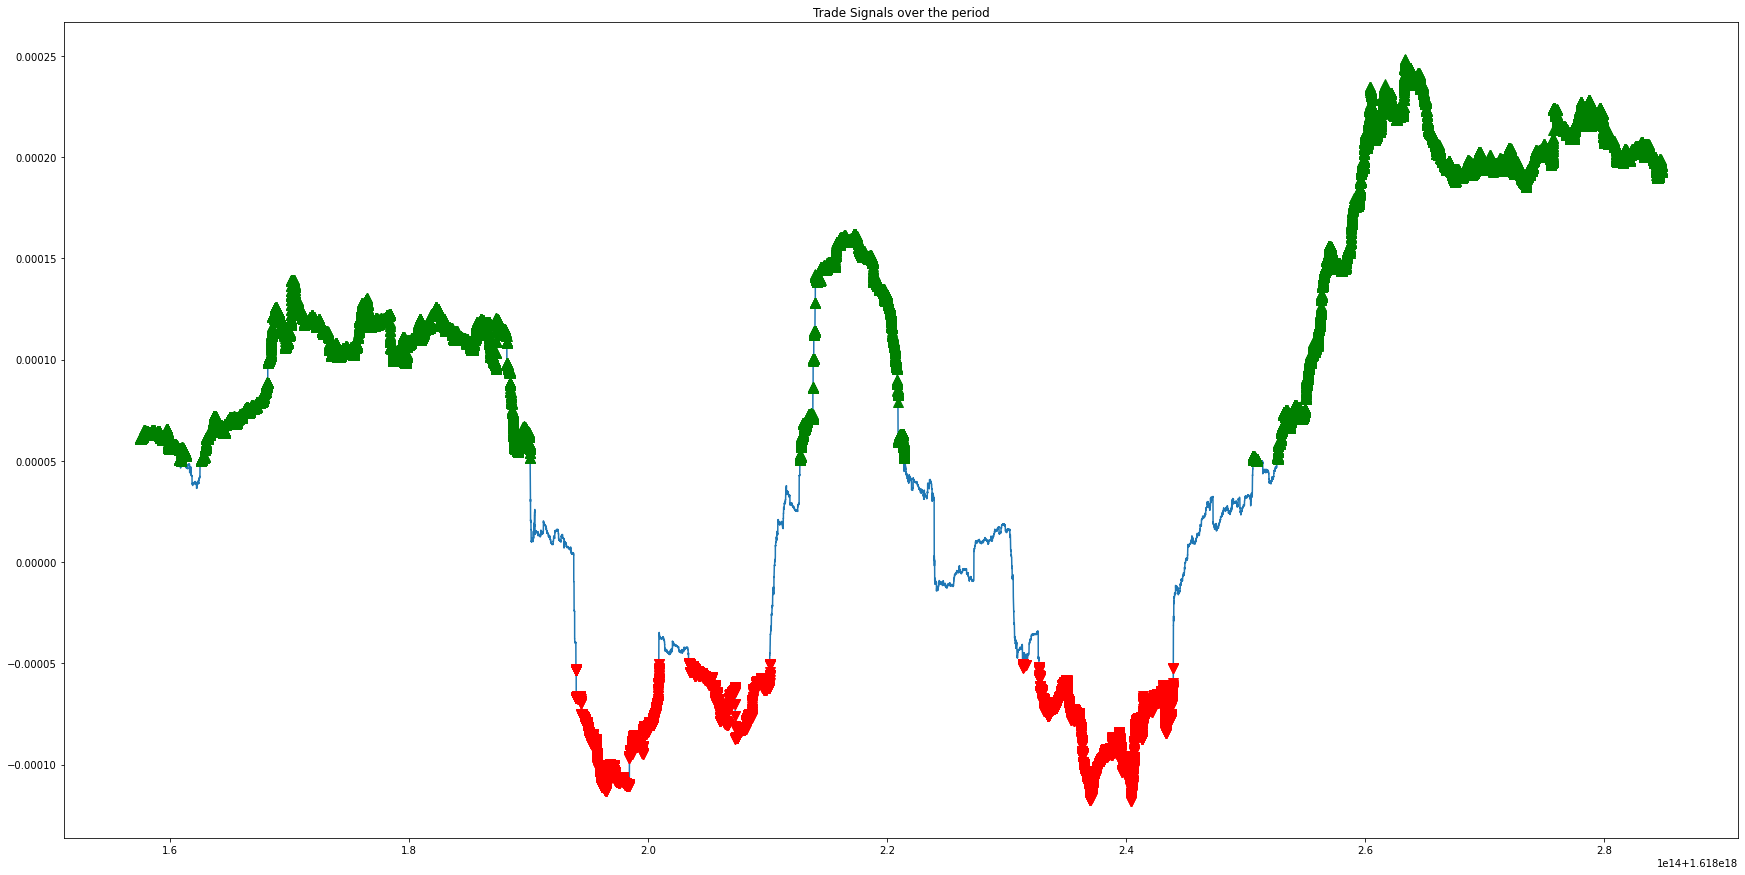

In [265]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

#### Changing Parameters

In [292]:
tau=600
T=100
j=5e-08
band=5e-05

In [293]:
tr_eth_usd['nside']= tr_eth_usd['Side'].apply(f1)
tr_eth_usd['flow'] = tr_eth_usd['SizeBillionths'] * tr_eth_usd['nside']

pair_tau= get_tau_flow(tr_eth_usd,tau)  
pair_price= get_T_price(tr_eth_usd,T) 

data,beta,pvalue, r_sqaured = run_reg(pair_tau,pair_price,j,band)



<AxesSubplot:title={'center':'Distribution of Returns'}, ylabel='Frequency'>

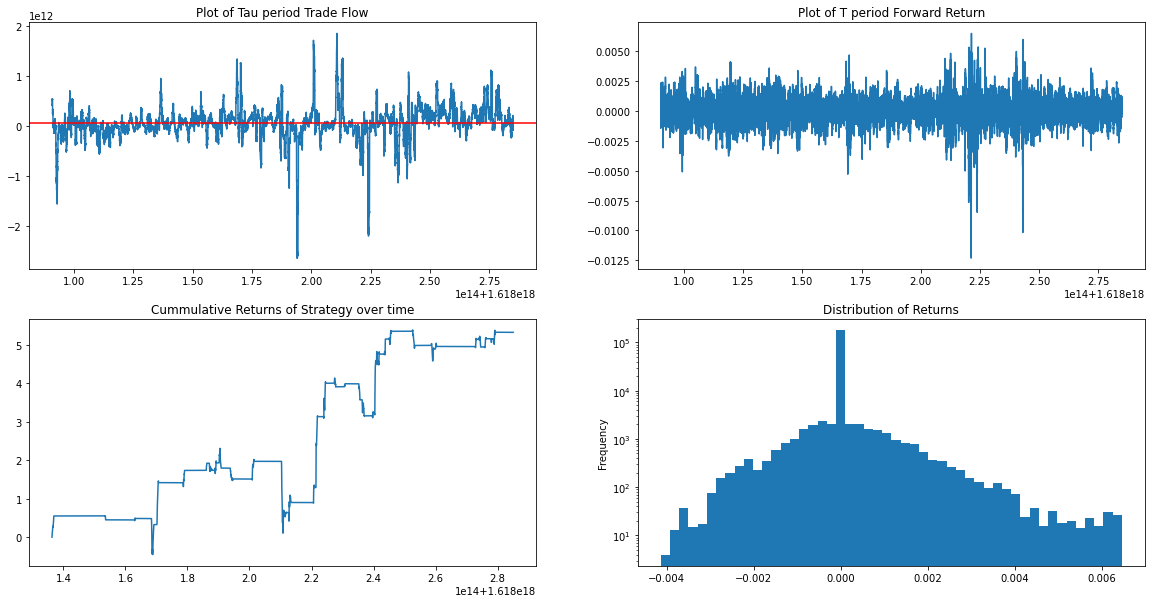

In [294]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
mean= pair_tau['tauFlow'].mean()
vol=pair_tau['tauFlow'].std()
median= pair_tau['tauFlow'].median()
ax[0][0].plot(pair_tau['tauFlow'])
ax[0][0].axhline(mean, c='r')
ax[0][0].set_title("Plot of Tau period Trade Flow")
textstr = '\n'.join((
r'$\mu=%.4f$' % (mean*100, ),
r'$\mathrm{median}=%.4f$' % (median*100, ),
r'$\sigma=%.4f$' % (vol*100, )))

ax[0][1].plot(pair_price['ret'])
ax[0][1].set_title("Plot of T period Forward Return")

ax[1][0].plot(data['realized_ret'].cumsum())
ax[1][0].set_title("Cummulative Returns of Strategy over time")

ax[1][1].set_title("Distribution of Returns")
data['realized_ret'].plot.hist(bins=50, log=True ,ax=ax[1][1])


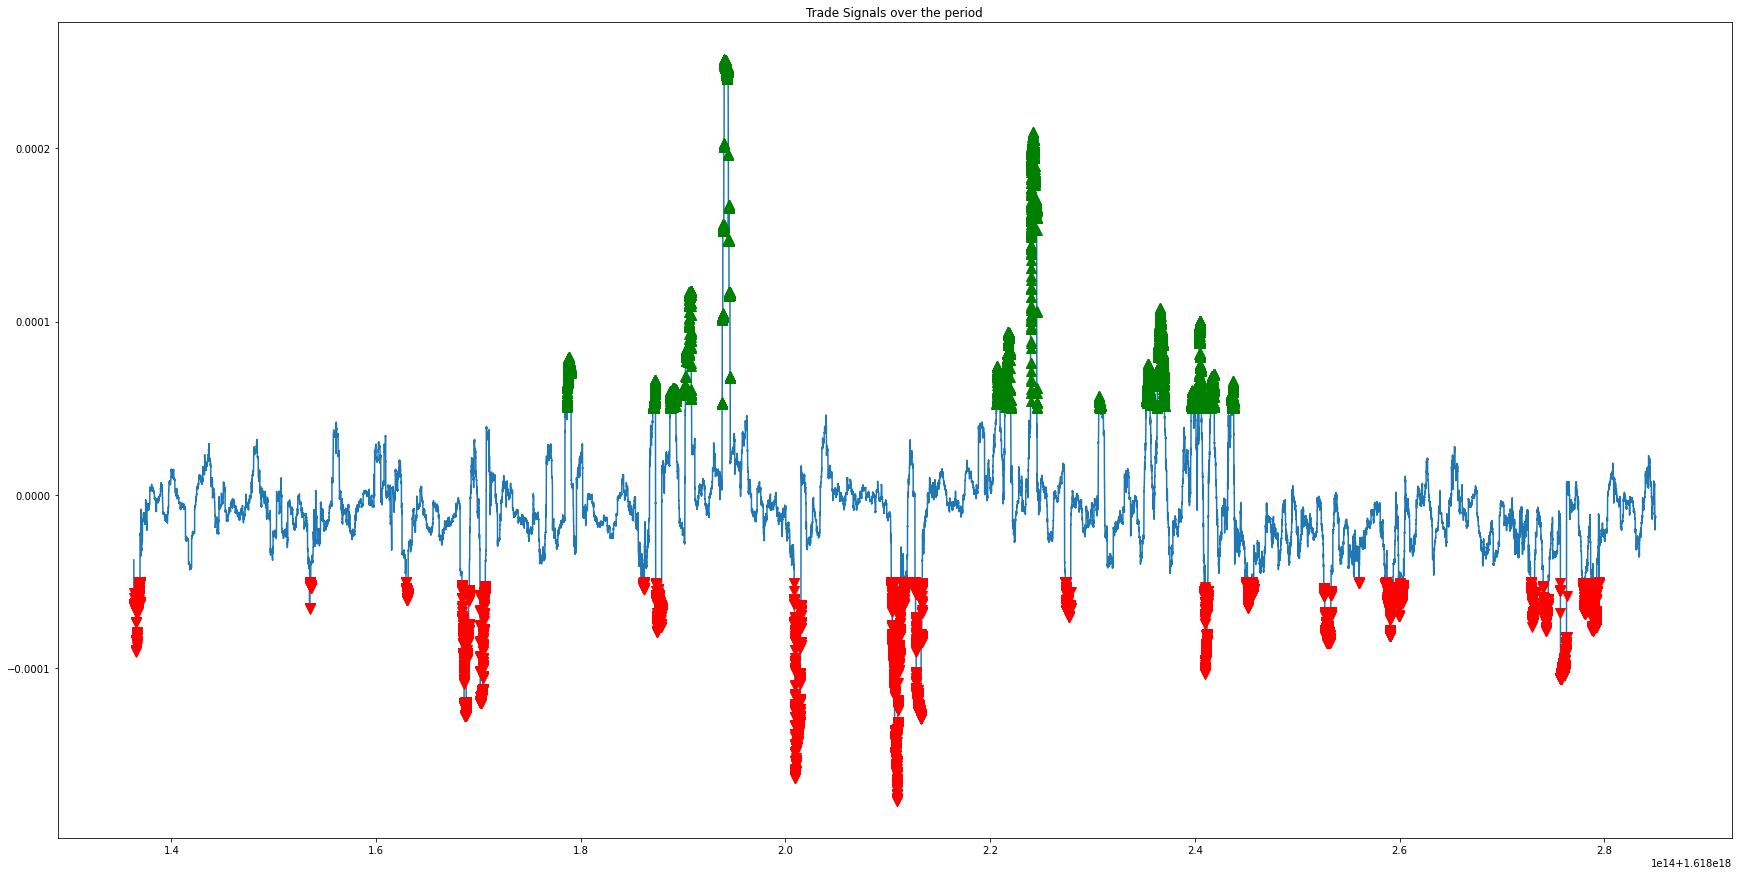

In [295]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(data['pred_ret'])
ax.plot(data[data["signal"] == 1].index, data[data["signal"] == 1]['pred_ret'],'^', markersize = 10, color='g', label='entry')
ax.plot(data[data["signal"] == -1].index, data[data["signal"] == -1]['pred_ret'],'v', markersize = 10, color='r', label='exit')
plt.title('Trade Signals over the period')
plt.show()

# Conclusion 

- This strategy is suspectible to large changes as evident by the graphs, showing large swings for a particular timeframes 
- It is very important to make sure that we do not induce lookahead bias in this stratgey, hence we must be carefull with data processing
- The stratgey also can generate lots of signals, but its prudent to restrict them. This increases the performance as we have seen above.
- The returns from this strategy fluctuates largely as we change the hyper parameters(tau, T, J)
- The startegy however would provides divirsification benefits as its beta to the market will be extremly low
- The R-sqaured was extremely low. This is of concern. 
- This was a basic implementation of a trade flow strategy, within a controlled env. 

### Future Steps 

- Backtest the performance of the strategy 
- Fine tune the parameters to determine optimal set
- Increase the r-sqaured 
- use volume adjusted flow 